In [209]:
import torch
from vit_pytorch import ViT
from models.binae import BinModel
from einops import rearrange
from pathlib import Path
import os

## Specify the configurations that you want to use to build your model

Here, pick the desired configuration depending on the weights that you downloaded from our repository. The weights can be downloaded from; https://github.com/dali92002/DocEnTR in the Section Model Zoo.

In [210]:
THRESHOLD = 0.5  ## binarization threshold after the model output
WORKERS = 4
SPLITSIZE = 256  ## your image will be divided into patches of 256x256 pixels
BATCH_SIZE = 1
OUTPUT_PATH = Path("./demo/cleaned")  #TODO: Add your desired output path here
setting = "base"  ## choose the desired model size [small, base or large], depending on the model you want to use
patch_size = 8  ## choose your desired patch size [8 or 16], depending on the model you want to use
dataset_year = 2018
image_size = (SPLITSIZE, SPLITSIZE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [211]:
if setting == 'base':
    encoder_layers = 6
    encoder_heads = 8
    encoder_dim = 768

elif setting == 'small':
    encoder_layers = 3
    encoder_heads = 4
    encoder_dim = 512

elif setting == 'large':
    encoder_layers = 12
    encoder_heads = 16
    encoder_dim = 1024
else:
    raise ValueError("Invalid setting!")

## Build your model
Build the transformer autoencoder model

In [212]:
v = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=1000,
    dim=encoder_dim,
    depth=encoder_layers,
    heads=encoder_heads,
    mlp_dim=2048
)
model = BinModel(
    encoder=v,
    decoder_dim=encoder_dim,
    decoder_depth=encoder_layers,
    decoder_heads=encoder_heads
)

model = model.to(device)

## Load the pretrained weights that were downloaded from our repo:
Here, give the path of the downloaded weights and load them to use a trained model.

In [213]:
model_path = Path("ADD PATH HERE", f"model_{patch_size}_{dataset_year}_{setting}.pt")  # TODO: Add the path to the model weights path here
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [214]:
import matplotlib.pyplot as plt

def showimg(img, torch_mode: bool = False):
    if torch_mode:
        img = torch.permute(img, (1, 2, 0))
    plt.figure()
    plt.imshow(img)
    plt.show()
    plt.close()

## Read the degraded image

Here specify the location of the degraded image that you want to clean. and then read it. We also can visualize it before cleaning. Here I have a folder named demo that contain two folders named degraded and cleaned, the degraded contain the degraded image and the cleaned will contain later the obtained results. But you can specify your own names of folders.

In [215]:
import math

from torch.utils.data import Dataset, DataLoader
from typing import Dict, Any, List, Tuple, Optional
from numpy.typing import ArrayLike
import numpy as np
import cv2

import torch

Height = int
Width = int

ImageShape = Tuple[Height, Width]


class BinarisationDataset(Dataset):
    def __init__(
            self,
            fnames: List[Path],
            imshape: Optional[ImageShape] = None,
    ) -> None:
        super().__init__()
        self.fnames = fnames
        self.imshape = imshape

    def __len__(self) -> int:
        return len(self.fnames)

    def __getitem__(self, item: int) -> Dict[str, Any]:
        img, og_shape, rs_shape = self._load_image(self.fnames[item])
        img = torch.tensor(img)
        return {
            "img": img,
            "og_shape": og_shape,
            "rs_shape": rs_shape,
            "fn_shape": self.imshape or (img.shape[0], img.shape[1]),
            "fname": self.fnames[item],
        }

    def _load_image(self, path: Path) -> Tuple[ArrayLike, ImageShape, ImageShape]:
        img = cv2.imread(str(path))
        og_shape = img.shape[0], img.shape[1]

        if self.imshape is not None:
            img, rs_shape = self._proportional_scaling(img)
        else:
            rs_shape = og_shape

        # This is a bug of the original training of the model. The code expects
        # OpenCV BGR images, but it normalises using RGB constants. If you re-train,
        # take this into consideration and switch the code approppriately.
        # Otherwise, if using the official checkpoints, you should use this code
        # as is.
        # Thankfully, thanks to the magic of Deep Learning(tm), the model works
        # regardless.

        # img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255).astype('float32')  # height, width, 3
        img = (img / 255).astype('float32')  # height, width, 3

        return img, og_shape, rs_shape

    def _proportional_scaling(self, img: ArrayLike) -> Tuple[ArrayLike, ImageShape]:
        """Scale image to a set width and height with padding."""
        img_height, img_width, img_channels = img.shape

        assert self.imshape is not None, "No resizing should be done if shape is None"
        height, width = self.imshape

        factor = min(height / img_height, width / img_width)
        new_height, new_width = int(img_height * factor + 0.999), int(
            img_width * factor + 0.999
        )

        img = cv2.resize(img, (new_width, new_height))
        padded = np.zeros((*self.imshape, img_channels), dtype=img.dtype)
        padded[:new_height, :new_width, :] = img

        return padded, (new_height, new_width)

    # You can implement your own dataset by writing a function that selects the images
    # to clean and passes them to the constructor as a list.
    @classmethod
    def from_old_docs(cls, root_path: Path, imshape: Optional[ImageShape]) -> "BinarisationDataset":
        return BinarisationDataset(list(root_path.glob("*/*.jpg")), imshape)

## Split and Merge functions

Here, two function that are used for splitting an image into patches and merge a list of patches into an image. 

In [216]:
class PatchProcessor:
    MEAN = torch.Tensor(np.array([0.485, 0.456, 0.406]))
    STD = torch.Tensor(np.array([0.229, 0.224, 0.225]))

    def __init__(self, nsize1: int, nsize2: int) -> None:
        self.nsize1 = nsize1
        self.nsize2 = nsize2

    def split(self, img: torch.Tensor) -> torch.Tensor:
        """Convert image into a set of patches."""
        # im: h x w x 3
        patches = rearrange(img, "(h p1) (w p2) c -> (h w) p1 p2 c", p1=self.nsize1, p2=self.nsize2, c=3)
        return patches

    def merge_image(self, patches: torch.Tensor, h: int, w: int) -> torch.Tensor:
        """Convert patches back into an image."""
        #patches: npatches x hpatch x wpatch x 3
        img = rearrange(patches, "(h w) p1 p2 c -> (h p1) (w p2) c", p1=self.nsize1, p2=self.nsize2, c=3,
                        h=h // self.nsize1, w=w // self.nsize2)
        return img

    def normalize_patches(self, patches: torch.Tensor) -> torch.Tensor:
        """Apply normalization on the color of the patches."""
        # patches: npatches x hpatch x wpatch x 3
        patches = (patches - self.MEAN[None, None, None, :]) / self.STD[None, None, None, :]
        return patches

    def unnormalize_patches(self, patches: torch.Tensor):
        # patches: npatches x hpatch x wpatch x 3
        patches = (patches * self.STD[None, None, None, :]) + self.MEAN[None, None, None, :]
        return patches

    @staticmethod
    def _closest_multiple(num: int, multiple: int) -> int:
        return (math.ceil(num / multiple)) * multiple

    def prepare_image(self, image: torch.Tensor):
        """Split the image intop patches, an image is padded first to make it dividable by the split size."""
        # image: h x w x 3
        h = self._closest_multiple(image.shape[0], self.nsize1)
        w = self._closest_multiple(image.shape[1], self.nsize2)

        image_padded = torch.ones((h, w, 3))
        image_padded[:image.shape[0], :image.shape[1], :] = image
        patches = self.split(image_padded)
        patches = self.normalize_patches(patches)
        # patches: npatches x hpatch x wpatch x 3
        return patches

    def unprepare_image(self, patches, rs_shape: ImageShape, fn_shape: ImageShape) -> torch.Tensor:
        # patches: npatches x hpatch x wpatch x 3
        h = self._closest_multiple(fn_shape[0], self.nsize1)
        w = self._closest_multiple(fn_shape[1], self.nsize2)

        patches = self.unnormalize_patches(patches)
        image = self.merge_image(patches, h, w)

        # image: h' x w' x 3
        image = image[:rs_shape[0], :rs_shape[1], :]

        return image


class PatchCollator:
    def __init__(self):
        self.processor = PatchProcessor(SPLITSIZE, SPLITSIZE)

    def get_processor(self) -> PatchProcessor:
        return self.processor

    def collate_fn(self, batch):
        output = {
            "patches": [],
            "npatches": [],
            "end_indices": [],
            "fnames": [],
            "og_shapes": [],
            "rs_shapes": [],
            "fn_shapes": [],
        }
        for sample in batch:
            img, og_shape, rs_shape, fn_shape, fname = sample["img"], sample["og_shape"], sample["rs_shape"], sample[
                "fn_shape"], sample["fname"]
            patches = self.processor.prepare_image(img)
            output["patches"].append(patches)
            output["npatches"].append(len(patches))
            output["fnames"].append(fname)
            output["og_shapes"].append(og_shape)
            output["rs_shapes"].append(rs_shape)
            output["fn_shapes"].append(fn_shape)
            output["end_indices"].append(
                len(patches) if len(output["end_indices"]) == 0 else output["end_indices"][-1] + len(patches))
        output["patches"] = torch.cat(output["patches"], dim=0)
        return output


In [217]:
collator = PatchCollator()
dataset = BinarisationDataset(list(Path("./demo/degraded/").glob("*")))  # TODO: Change your dataset here
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator.collate_fn,
                        num_workers=WORKERS, pin_memory=False, drop_last=False)

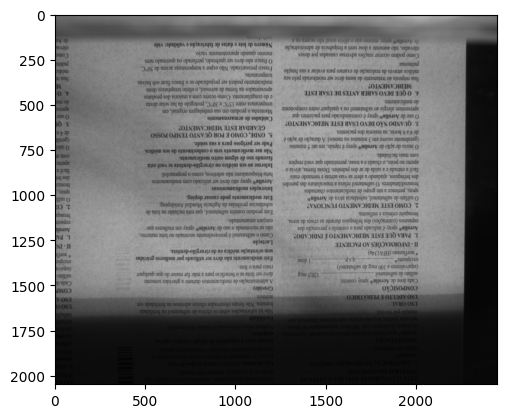

In [218]:
showimg(dataset[1]["img"])

## Clean your image with the trained model

Clean your list of patches obe by one.

In [219]:
def export_image(pred_patches: torch.Tensor, batch: Dict[str, Any]) -> None:
    prev = 0
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    for jj, (end_ind, og_shape, rs_shape, fn_shape, fname) in enumerate(
            zip(batch["end_indices"], batch["og_shapes"], batch["rs_shapes"], batch["fn_shapes"], batch["fnames"])):
        img_patches = pred_patches[prev: end_ind]
        img_clean = processor.unprepare_image(img_patches, rs_shape, fn_shape)
        prev = end_ind
        img_clean = (img_clean.numpy() > THRESHOLD) * 255
        img_clean = img_clean.astype(np.uint8)
        cv2.imwrite(str(OUTPUT_PATH / f"{fname.stem}.png"), cv2.cvtColor(img_clean, cv2.COLOR_RGB2BGR))

In [220]:
from multiprocessing.pool import ThreadPool

thread_pool = ThreadPool(8 - WORKERS)
result = []
processor = collator.get_processor()

for ii, batch in enumerate(dataloader):
    train_in = batch["patches"]

    with torch.no_grad():
        train_in = train_in.to(device)
        train_in = train_in.permute(0, 3, 1, 2)  # b, ch, h, w
        any_img = torch.rand(train_in.shape).to(device)
        _, _, pred_patches = model(train_in, any_img)
        pred_patches = torch.squeeze(
            rearrange(pred_patches, 'b (h w) (p1 p2 c) -> b (h p1) (w p2) c', p1=patch_size, p2=patch_size,
                      h=image_size[0] // patch_size))
        pred_patches = pred_patches.detach().cpu()
        export_thread = thread_pool.apply(export_image, [pred_patches, batch])